In [7]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
import datetime
datetime.datetime

datetime.datetime

In [18]:
# Utils
import matplotlib.pyplot as plt
import numpy as np

# save checkpoint
# Function to save model checkpoint
def save_checkpoint(model, scaler, threshold, path='model_checkpoint.pth'):
    checkpoint = {
        'state_dict': model.state_dict(),
        'threshold': threshold,
        'scaler': scaler
    }
    torch.save(checkpoint, path)
    print(f'Checkpoint saved at epoch')

def load_checkpoint(path, model):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    model.threshold = checkpoint['threshold']
    model.scaler = checkpoint['scaler']
    return model


def plot_time_series(time_series, prediction, title='Time Series with Quantiles'):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    plt.plot(prediction, label='Predition', color='orange')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_time_series_with_errors_area(time_series, prediction, error_low, error_high):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    plt.plot(prediction, label='Predition', color='orange')
    plt.fill_between(np.arange(0, len(time_series)), error_low, error_high, alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plot_time_series_with_quantiles(time_series, quantiles, seq_length, title='Time Series with Quantiles'):
    """
    Plots the real time series and quantiles predicted by the autoencoder.

    Parameters:
    - time_series: numpy array of the actual time series values.
    - quantiles: numpy array of shape (n_samples, n_quantiles, seq_length) containing the predicted quantiles.
    - seq_length: int, length of the sequence used for the predictions.
    - title: str, title of the plot.
    """
    
    # Plot the actual time series
    plt.figure(figsize=(14, 8))
    plt.plot(time_series, label='Actual Time Series', color='blue')
    
    # Plot the quantiles
    for index in range(0, len(quantiles)//2):
        print(quantiles[index])
        print(quantiles[len(quantiles)-index-1])
        plt.fill_between(np.arange(0, len(time_series)), 
                         quantiles[index], quantiles[len(quantiles)-index-1], label=f'Quantile {index+1}', alpha=0.3)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()



In [19]:
def get_scaler(values):
    values = values.reshape(-1, 1)
    scaler = StandardScaler()
    scaler = scaler.fit(values)
    return scaler


def create_dataloader(values, scaler, seq_length, train_ratio):
    values = values.reshape(-1, 1)

    # Normalize the data
    values_scaled = scaler.transform(values)

    # Create sequences
    def create_sequences(data, seq_length):
        sequences = []
        for i in range(len(data) - seq_length):
            sequences.append(data[i:i + seq_length])
        return np.array(sequences)

    train_size = int(train_ratio * len(values_scaled))
    train_data = values_scaled[:train_size]
    val_data = values_scaled[train_size:]

    X_train = create_sequences(train_data, seq_length)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    train_dataset = TensorDataset(X_train, X_train)

    X_val = create_sequences(val_data, seq_length)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    val_dataset = TensorDataset(X_val, X_val)
    
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return train_data, val_data, train_dataset, val_dataset, train_dataloader, val_dataloader

In [20]:
throughput = pd.read_csv('./../data/throughput.csv', parse_dates=['point'])
web_response = pd.read_csv('./../data/web_response.csv', parse_dates=['point'])
apdex = pd.read_csv('./../data/apdex.csv', parse_dates=['point'])
error = pd.read_csv('./../data/error.csv', parse_dates=['point'])
SEQ_LEN = 128

In [21]:
data = throughput

In [22]:
data['point'] = pd.to_datetime(data['point'])
data.set_index('point', inplace=True)
result = seasonal_decompose(data['value'], model='additive', period=1440)  # Period is the number of minutes in a day
data['de_seasonalized'] = data['value'] - result.seasonal
data.reset_index(inplace=True)

Comvolutional

In [23]:
class ConvAutoencoder(pl.LightningModule):
    def __init__(self, loss, hidden_size, seq_len, dropout_prob):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_size, 3, padding=1),  # Output: [batch_size, 32, seq_len]
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),       # Output: [batch_size, 32, seq_len//2]
            nn.Conv1d(hidden_size, hidden_size//2, 3, padding=1), # Output: [batch_size, 16, seq_len//2]
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),       # Output: [batch_size, 16, seq_len//4]
            nn.Conv1d(hidden_size//2, hidden_size//4, 3, padding=1),  # Output: [batch_size, 8, seq_len//4]
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2)        # Output: [batch_size, 8, seq_len//8]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_size//4, hidden_size//2, 4, stride=2, padding=1), # Output: [batch_size, 16, seq_len//4]
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size//2, hidden_size, 4, stride=2, padding=1), # Output: [batch_size, 32, seq_len//2]
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, 1, 4, stride=2, padding=1),  # Output: [batch_size, 1, seq_len]
        )
        self.loss = loss
        self.seq_len = seq_len
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch_size, seq_len, 1] -> [batch_size, 1, seq_len]
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.permute(0, 2, 1)  # [batch_size, 1, seq_len] -> [batch_size, seq_len, 1]
        return decoded
    
    def training_step(self, batch, batch_idx):
        inputs, _ = batch
        outputs = self(inputs)
        loss = self.loss(outputs, inputs.permute(0, 2, 1))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)


In [24]:
scaler = get_scaler(data['de_seasonalized'].values)
train_data, val_data, train_dataset, val_dataset, train_dataloader, val_dataloader = create_dataloader(data['de_seasonalized'].values, scaler, SEQ_LEN, 0.8)

In [25]:
# Instantiate the model
model = ConvAutoencoder(hidden_size=128, loss=nn.L1Loss(), seq_len=SEQ_LEN, dropout_prob=0.1)
# Initialize EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=7,          # Number of epochs with no improvement to stop training
    verbose=True,        # Enable verbose mode
    mode='min'           # Mode 'min' to stop when the metric stops decreasing
)
# Initialize ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',      # Metric to monitor
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Filename for the best checkpoint
    save_top_k=1,            # Save only the best checkpoint
    mode='min',              # Mode 'min' to save the checkpoint with the lowest 'val_loss'
    save_last=True,          # Save the final model
    verbose=True
)
checkpoint_callback = ModelCheckpoint('./')
trainer = pl.Trainer(max_epochs=8, logger=True, log_every_n_steps=1, val_check_interval=500, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory D:\projects\code\red-hack-time-series-analyzer\notebooks exists and is not empty.

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 31.3 K
1 | decoder | Sequential | 41.7 K
2 | loss    | L1Loss     | 0     
---------------------------------------
73.0 K    Trainable params
0         Non-trainable params
73.0 K    Total params
0.292     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 11.77it/s]

d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/1078 [00:00<?, ?it/s] 

d:\courses\MLsimulator\venv\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([32, 1, 128])) that is different to the input size (torch.Size([32, 128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0:  46%|████▋     | 500/1078 [00:18<00:21, 26.69it/s, v_num=1, train_loss_step=0.377]

Metric val_loss improved. New best score: 0.245


Epoch 0:  93%|█████████▎| 1000/1078 [00:46<00:03, 21.37it/s, v_num=1, train_loss_step=0.363, val_loss_step=0.299, val_loss_epoch=0.245]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.242


Epoch 1:   0%|          | 3/1078 [00:00<00:46, 23.11it/s, v_num=1, train_loss_step=0.361, val_loss_step=0.283, val_loss_epoch=0.242, train_loss_epoch=0.391]   

d:\courses\MLsimulator\venv\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([25, 1, 128])) that is different to the input size (torch.Size([25, 128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1:  46%|████▋     | 500/1078 [00:19<00:22, 25.69it/s, v_num=1, train_loss_step=0.382, val_loss_step=0.283, val_loss_epoch=0.242, train_loss_epoch=0.391]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.237


Epoch 4:  93%|█████████▎| 1000/1078 [00:44<00:03, 22.33it/s, v_num=1, train_loss_step=0.430, val_loss_step=0.272, val_loss_epoch=0.243, train_loss_epoch=0.371]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.237. Signaling Trainer to stop.


Epoch 4:  93%|█████████▎| 1000/1078 [00:49<00:03, 20.09it/s, v_num=1, train_loss_step=0.430, val_loss_step=0.271, val_loss_epoch=0.240, train_loss_epoch=0.370]


In [28]:
def evaluate_threshhold(model, val_dataloader):
    model.eval()  # Set model to evaluation mode
    val_loss = []
    with torch.no_grad():  # Disable gradient calculation
        for x, y in val_dataloader:
            y_hat = model(x)
            loss = np.abs(y_hat - y)
            val_loss.append(loss.numpy())
    return val_loss

In [29]:
errors = evaluate_threshhold(model, val_dataloader)
errors = np.concatenate(errors).ravel()
threshold = np.quantile(errors, 0.99)
model.threshold = threshold

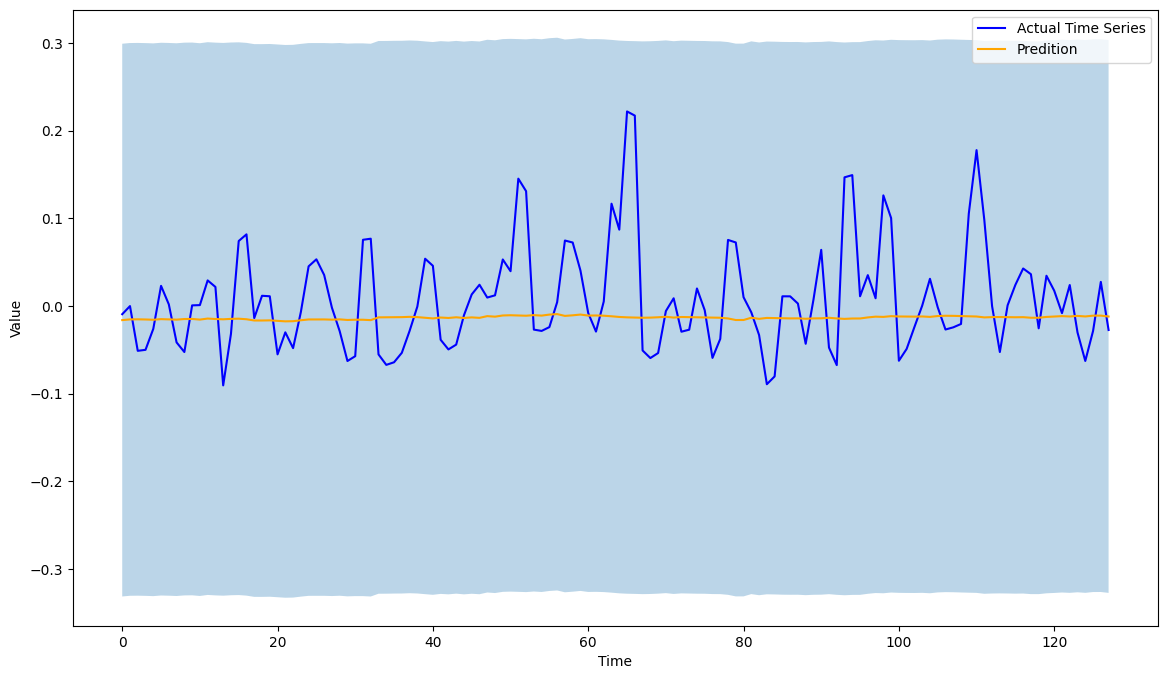

In [540]:
model.eval()
with torch.no_grad():
    i = np.random.randint(0, len(val_dataset))
    series = val_dataset[i][0].unsqueeze(0)
    pred = model(val_dataset[i][0].unsqueeze(0))
    # plot the time series
plot_time_series_with_errors_area(series.squeeze().numpy(), pred.squeeze().numpy(), pred.squeeze().numpy()+model.threshold, pred.squeeze().numpy()-model.threshold)

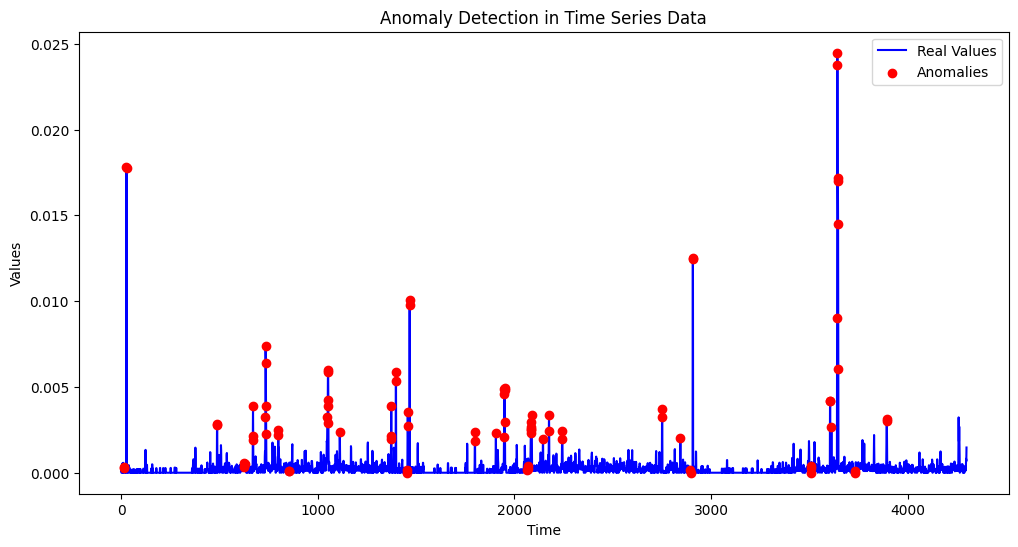

In [541]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train and y_train are your data tensors
# Example:
# x_train = torch.randn(1000, 10, 10)  # 1000 samples, sequence length 10, 10 features each
# y_train = torch.randn(1000, 10, 10)  # 1000 samples, sequence length 10, 10 targets each

# Define a function to analyze the time series using the model
def detect_anomalies(model, time_series, threshold, window_size):
    model.eval()  # Set the model to evaluation mode
    anomalies = []
    predicted_values = []
    with torch.no_grad():  # Disable gradient calculation
        for i in range(0, len(time_series) - window_size + 1, window_size):
            window = time_series[i:i + window_size].unsqueeze(0)  # Add batch dimension
            prediction = model(window).squeeze(0)
            predicted_values.extend(prediction.tolist())

            error = torch.abs(prediction - window.squeeze(0))
            for j in range(window_size):
                if error[j].item() > threshold:
                    anomalies.append(i + j)  # Mark the specific point as an anomaly
    return anomalies, predicted_values

# Example time series data (replace with your actual data)
time_series_data = data['value'].values[0:4300].reshape(-1, 1)  # Replace with your actual time series data
deseasonalized = torch.FloatTensor(scaler.transform(data['de_seasonalized'].values[0:4300].reshape(-1, 1)))
window_size = SEQ_LEN  # Replace with your actual window size
threshold = model.threshold  # Replace with your actual threshold for anomaly detection

# Detect anomalies
anomalies, predicted_values = detect_anomalies(model, deseasonalized, threshold, window_size)

# Convert lists to numpy arrays for easier plotting
predicted_values = np.array(predicted_values).flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Real Values', color='blue')
plt.scatter(anomalies, time_series_data[anomalies], color='red', label='Anomalies', zorder=5)
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Anomaly Detection in Time Series Data')
plt.show()


In [444]:
data

,point,value,de_seasonalized
0,2024-04-15 23:32:00,0.999679,0.999191
1,2024-04-15 23:33:00,0.999745,0.999275
2,2024-04-15 23:34:00,0.999687,0.999091
3,2024-04-15 23:35:00,0.999812,0.999340
4,2024-04-15 23:36:00,0.999489,0.999181
...,...,...,...
43267,2024-05-16 00:54:00,0.998828,0.997923
43268,2024-05-16 00:55:00,0.998495,0.997597
43269,2024-05-16 00:56:00,0.997736,0.996918
43270,2024-05-16 00:57:00,0.997999,0.997213


In [543]:
save_checkpoint(model=model, scaler=scaler, threshold=model.threshold*10, path='apdex_model.pth')

Checkpoint saved at epoch


In [442]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.1.0
aiohttp                      3.9.5
aiosignal                    1.3.1
asttokens                    2.4.1
astunparse                   1.6.3
async-timeout                4.0.3
attrs                        23.2.0
certifi                      2023.11.17
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.0
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
exceptiongroup               1.2.0
executing                    2.0.1
filelock                     3.13.1
flatbuffers                  24.3.25
fonttools                    4.52.1
frozenlist                   1.4.1
fsspec                       2023.12.2
gast                         0.5.4
google-pasta                 0.2.0
grpcio                       1.64.0
h5py                         3


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Becnhmark

LSTM TRAINING

In [214]:
import torch
import torch.nn as nn

class LSTMModel(pl.LightningModule):
    def __init__(self, input_dim, seq_len, hidden_dim=128, dropout_rate=0.2, loss=nn.L1Loss()):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.input_dim = input_dim
        
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.repeat_vector = lambda x: x.unsqueeze(1).repeat(1, self.seq_len, 1)
        
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.time_distributed_dense = nn.Linear(hidden_dim, input_dim)
        self.loss = loss

    def forward(self, x):
        # LSTM layer
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        
        # RepeatVector
        x = self.repeat_vector(x[:, -1, :])
        
        # LSTM layer
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        
        # TimeDistributed Dense layer
        x = self.time_distributed_dense(x)
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, _ = batch
        y_pred = self(x)
        loss = self.loss(y_pred, x)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer
    
    # Function to evaluate model on validation set
    def evaluate_threshhold(self, val_loader, percentile):
        self.eval()  # Set model to evaluation mode
        val_loss = []
        criterion = nn.L1Loss()
        with torch.no_grad():  # Disable gradient calculation
            for x, y in val_loader:
                y_hat = self(x)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
        THRESHOLD = np.percentile(val_loss, percentile)
        self.threshold = THRESHOLD
        return THRESHOLD


array([3898. , 3917.5, 3993. , ..., 2429. , 2373.5, 1170. ])

In [223]:
scaler = get_scaler(data['value'].values)
dataset, train_dataloader, val_dataloader = create_dataloader(data['value'].values, scaler, 20, 0.8)

In [225]:
# Instantiate the model
model = LSTMModel(input_dim=1, hidden_dim=128, seq_len=20)
# Initialize EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=0,          # Number of epochs with no improvement to stop training
    verbose=True,        # Enable verbose mode
    mode='min'           # Mode 'min' to stop when the metric stops decreasing
)
# Initialize ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',      # Metric to monitor
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Filename for the best checkpoint
    save_top_k=1,            # Save only the best checkpoint
    mode='min',              # Mode 'min' to save the checkpoint with the lowest 'val_loss'
    save_last=True,          # Save the final model
    verbose=True
)
checkpoint_callback = ModelCheckpoint('./')
trainer = pl.Trainer(max_epochs=2, logger=True, log_every_n_steps=1, val_check_interval=100, callbacks=[early_stop_callback, checkpoint_callback])
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                   | Type    | Params
---------------------------------------------------
0 | lstm1                  | LSTM    | 67.1 K
1 | dropout1               | Dropout | 0     
2 | lstm2                  | LSTM    | 132 K 
3 | dropout2               | Dropout | 0     
4 | time_distributed_dense | Linear  | 129   
5 | loss                   | L1Loss  | 0     
---------------------------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 87.72it/s]

d:\courses\MLsimulator\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0:   9%|▉         | 100/1082 [00:02<00:24, 40.56it/s, v_num=47, train_loss_step=0.237]

Metric val_loss improved. New best score: 0.259


Epoch 0:  18%|█▊        | 200/1082 [00:08<00:36, 24.18it/s, v_num=47, train_loss_step=0.168, val_loss_step=0.268, val_loss_epoch=0.259]

Metric val_loss improved by 0.078 >= min_delta = 0.0. New best score: 0.181


Epoch 0:  28%|██▊       | 300/1082 [00:14<00:36, 21.18it/s, v_num=47, train_loss_step=0.172, val_loss_step=0.137, val_loss_epoch=0.181]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.159


Epoch 0:  37%|███▋      | 400/1082 [00:20<00:34, 19.82it/s, v_num=47, train_loss_step=0.195, val_loss_step=0.198, val_loss_epoch=0.159]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.154


Epoch 0:  46%|████▌     | 500/1082 [00:26<00:31, 18.71it/s, v_num=47, train_loss_step=0.188, val_loss_step=0.110, val_loss_epoch=0.154]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.152


Epoch 0:  55%|█████▌    | 600/1082 [00:33<00:26, 18.14it/s, v_num=47, train_loss_step=0.155, val_loss_step=0.165, val_loss_epoch=0.152]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.147


Epoch 0:  65%|██████▍   | 700/1082 [00:40<00:21, 17.38it/s, v_num=47, train_loss_step=0.174, val_loss_step=0.0837, val_loss_epoch=0.147]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.147


Epoch 0:  74%|███████▍  | 800/1082 [00:47<00:16, 16.84it/s, v_num=47, train_loss_step=0.121, val_loss_step=0.134, val_loss_epoch=0.147] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.144


Epoch 0:  83%|████████▎ | 900/1082 [00:54<00:10, 16.67it/s, v_num=47, train_loss_step=0.148, val_loss_step=0.128, val_loss_epoch=0.144] 

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.143


Epoch 0:  92%|█████████▏| 1000/1082 [01:01<00:05, 16.30it/s, v_num=47, train_loss_step=0.106, val_loss_step=0.397, val_loss_epoch=0.143]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.142


Epoch 1:   9%|▉         | 100/1082 [00:02<00:25, 38.33it/s, v_num=47, train_loss_step=0.136, val_loss_step=0.126, val_loss_epoch=0.142, train_loss_epoch=0.211] 

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.140


Epoch 1:  18%|█▊        | 200/1082 [00:09<00:40, 21.89it/s, v_num=47, train_loss_step=0.199, val_loss_step=0.116, val_loss_epoch=0.140, train_loss_epoch=0.211]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.139


Epoch 1:  28%|██▊       | 300/1082 [00:15<00:40, 19.45it/s, v_num=47, train_loss_step=0.185, val_loss_step=0.102, val_loss_epoch=0.139, train_loss_epoch=0.211] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.139


Epoch 1:  37%|███▋      | 400/1082 [00:22<00:37, 17.98it/s, v_num=47, train_loss_step=0.105, val_loss_step=0.0912, val_loss_epoch=0.139, train_loss_epoch=0.211] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.139


Epoch 1:  46%|████▌     | 500/1082 [00:28<00:33, 17.35it/s, v_num=47, train_loss_step=0.166, val_loss_step=0.138, val_loss_epoch=0.139, train_loss_epoch=0.211] 

Monitored metric val_loss did not improve in the last 1 records. Best score: 0.139. Signaling Trainer to stop.


Epoch 1:  46%|████▌     | 500/1082 [00:32<00:38, 15.29it/s, v_num=47, train_loss_step=0.166, val_loss_step=0.121, val_loss_epoch=0.143, train_loss_epoch=0.151]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1:  46%|████▌     | 500/1082 [00:32<00:38, 15.29it/s, v_num=47, train_loss_step=0.166, val_loss_step=0.121, val_loss_epoch=0.143, train_loss_epoch=0.151]


# Benchmarks

In [523]:
import json
path_base ='.\\..\\data\\numenta\\'

with open(path_base + 'labels\\raw\\SA_labels_v0.8.json') as file:
    nab_files = json.loads(file.read())

<Axes: >

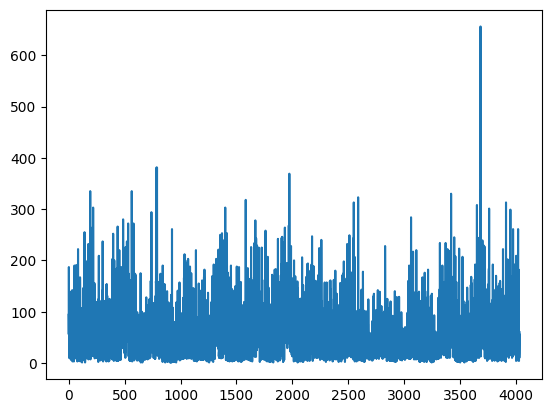

In [468]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import precision_score, recall_score, f1_score

# Example anomaly detection model (replace with your model)
def detect_anomalies(time_series):
    # Dummy implementation: Replace with your model's logic
    anomalies = time_series[time_series > time_series.mean() + 2 * time_series.std()]
    return anomalies.index

# The provided JSON structure as a dictionary
nab_files = {
    "artificialNoAnomaly/art_daily_no_noise.csv": [],
    "artificialNoAnomaly/art_daily_perfect_square_wave.csv": [],
    "artificialNoAnomaly/art_daily_small_noise.csv": [],
    "artificialNoAnomaly/art_flatline.csv": [],
    "artificialNoAnomaly/art_noisy.csv": [],
    "artificialWithAnomaly/art_daily_flatmiddle.csv": [
        "2014-04-11 00:00:00"
    ],
    # ... (other entries truncated for brevity)
    "realTweets/Twitter_volume_UPS.csv": [
        "2015-03-03 00:27:53",
        "2015-03-04 11:07:53",
        "2015-03-05 15:22:53",
        "2015-03-24 18:17:53",
        "2015-03-29 16:27:53"
    ]
}

def load_csv(file_path):
    return pd.read_csv(file_path, index_col=0, parse_dates=True)

def evaluate_model(nab_files):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for file_path, ground_truth_str in nab_files.items():
        # Load the time series data
        try:
            time_series = load_csv(file_path)
            if time_series.empty:
                continue

            # Assuming the time series data is in the first column
            time_series = time_series.iloc[:, 0]

            # Detect anomalies using the provided model
            detected_anomalies = detect_anomalies(time_series)

            # Convert ground truth to datetime
            ground_truth = [pd.to_datetime(gt) for gt in ground_truth_str]

            # Generate binary labels for the entire time series
            true_labels = np.zeros(len(time_series), dtype=int)
            for gt in ground_truth:
                window_start = gt - timedelta(minutes=5)  # Example scoring window of 5 minutes
                window_end = gt + timedelta(minutes=5)
                true_labels[(time_series.index >= window_start) & (time_series.index <= window_end)] = 1

            predicted_labels = np.zeros(len(time_series), dtype=int)
            predicted_labels[time_series.index.isin(detected_anomalies)] = 1

            # Calculate metrics
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
        
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    # Aggregate metrics
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_precision, avg_recall, avg_f1

# Evaluate the model
avg_precision, avg_recall, avg_f1 = evaluate_model(nab_files)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")


In [34]:
throughput: 4.392910301685333
error: 3.1539788842201233
apdex: 3.6294931173324585


{'state_dict': OrderedDict([('encoder.0.weight',
               tensor([[[-0.3823, -0.3785,  0.3640]],
               
                       [[-0.0029, -0.0957,  0.4997]],
               
                       [[ 0.0703,  0.4885,  0.4990]],
               
                       [[ 0.1841, -0.4690, -0.1646]],
               
                       [[ 0.1948,  0.1470,  0.3263]],
               
                       [[ 0.2482, -0.1952,  0.1221]],
               
                       [[ 0.0411, -0.4048, -0.3344]],
               
                       [[-0.3784, -0.1846,  0.3187]],
               
                       [[-0.1473, -0.4902, -0.4706]],
               
                       [[ 0.4062, -0.1980,  0.4951]],
               
                       [[-0.4831,  0.2969, -0.1126]],
               
                       [[ 0.4500, -0.2508, -0.5537]],
               
                       [[ 0.4473,  0.5439,  0.1104]],
               
                       [[ 0.3333, -0.2276

In [60]:
import torch

apdex = '.\\..\\backend\\resources\\models\\throughput_model.pth'
apdex_threshold = torch.load(apdex)
#

In [61]:
apdex_threshold['threshold']

3.1

In [62]:
apdex_threshold['threshold'] = 4.392910301685333

In [63]:
torch.save(apdex_threshold, apdex)